# Visualization of the Expert Action Distribution

**Objective:** To load the pre-computed action frequency data and generate a
2D heatmap. This plot visually represents the "Action Probability Map"
and confirms the extreme data imbalance, justifying our use of the
WeightedMSELoss and the action-rarity criticality score.

In [ ]:
# ## 1. Setup and Data Loading

import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config

# Load project config to get the correct file paths
config = load_config(config_path='../configs/main_config.yaml')

# --- Plotting Style Configuration ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

Configuration loaded successfully.


In [2]:
# ## 2. Load Pre-Computed Action Weights
# 
# We load the `action_weights_v2.pt` file, which contains the inverse frequency
# weights and the bin definitions.

# --- Load the Data ---
weights_path = os.path.join(
    os.path.dirname(config['data']['feature_stats_path_v2']), 
    'action_weights_v2.pt'
)

if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Action weights file not found at: {weights_path}\n"
                            "Please run `src/data_processing/compute_action_weights.py` first.")

weight_data = torch.load(weights_path)
action_weights = weight_data['weights'].numpy()
accel_bins = weight_data['accel_bins'].numpy()
steer_bins = weight_data['steer_bins'].numpy()

print("Action weights and bins loaded successfully.")
print(f"Histogram shape: {action_weights.shape}")

Action weights and bins loaded successfully.
Histogram shape: (89, 89)


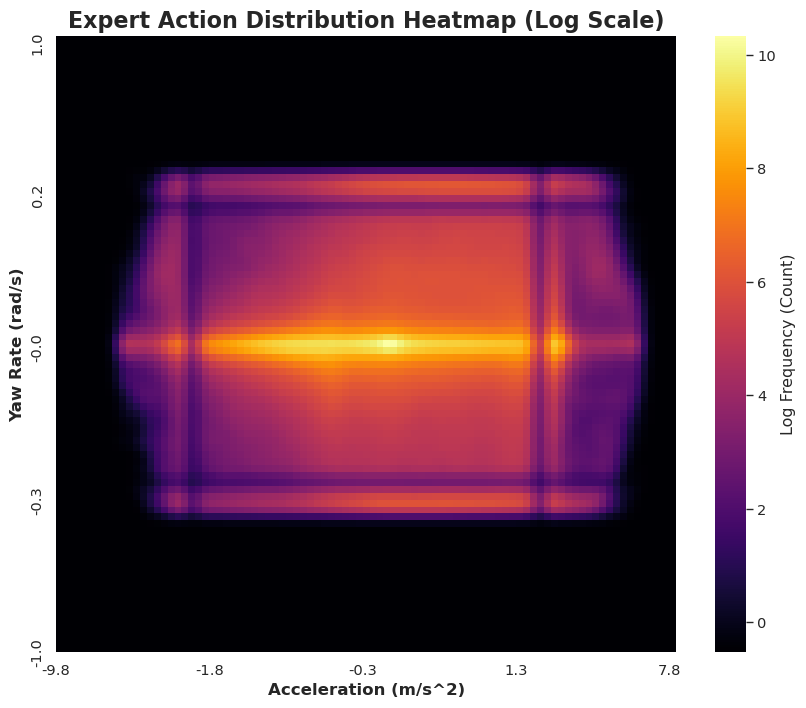

In [5]:
# ## 3. Reconstruct and Visualize the Action Distribution
# 
# The saved weights are the *inverse* frequency. To visualize the actual
# distribution, we first need to recover the original frequency counts. We
# will then plot this as a heatmap.
from scipy.ndimage import gaussian_filter

# +
# --- Recover Original Frequencies ---
# The formula was: weight = 1 / (frequency + 1).
# So, frequency = (1 / weight) - 1.
# We must handle the case where weight is zero, although it shouldn't be.
epsilon = 1e-9
original_frequencies = (1.0 / (action_weights + epsilon)) - 1.0

# For visualization, it's better to use the logarithm of the frequencies
# to handle the extreme concentration at the center. We add 1 to avoid log(0).
log_frequencies = np.log1p(original_frequencies)

sigma = 1.0 
smoothed_log_frequencies = gaussian_filter(log_frequencies, sigma=sigma)

# --- Create the Heatmap ---
plt.figure(figsize=(10, 8))

# Use imshow for a pixel-based heatmap. Transpose for correct axis orientation.
ax = sns.heatmap(
    smoothed_log_frequencies.T, # Transpose so acceleration is on x-axis
    cmap="inferno",    # 'inferno' is a great "hotspot" colormap
    cbar=True,
    cbar_kws={'label': 'Log Frequency (Count)'}
)

# --- Set Correct Axis Ticks and Labels ---
# We want the ticks to be at the bin centers, not the indices
accel_bin_centers = (accel_bins[:-1] + accel_bins[1:]) / 2
steer_bin_centers = (steer_bins[:-1] + steer_bins[1:]) / 2

# Set ticks at a reasonable interval
xtick_indices = np.linspace(0, len(accel_bin_centers)-1, 5).astype(int)
ytick_indices = np.linspace(0, len(steer_bin_centers)-1, 5).astype(int)

ax.set_xticks(xtick_indices)
ax.set_yticks(ytick_indices)

ax.set_xticklabels([f"{accel_bin_centers[i]:.1f}" for i in xtick_indices])
ax.set_yticklabels([f"{steer_bin_centers[i]:.1f}" for i in ytick_indices])

ax.invert_yaxis() # Put (0,0) at the center visually if desired, or leave as is

plt.xlabel("Acceleration (m/s^2)", fontsize=12, weight='bold')
plt.ylabel("Yaw Rate (rad/s)", fontsize=12, weight='bold')
plt.title("Expert Action Distribution Heatmap (Log Scale)", fontsize=16, weight='bold')

# Save the figure
# plt.savefig('../outputs/figure_action_distribution.png', dpi=300, bbox_inches='tight')
# plt.savefig('../outputs/figure_action_distribution.pdf', bbox_inches='tight')

plt.show()

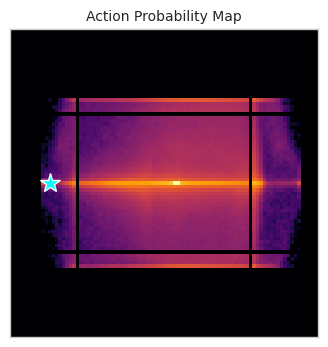

In [4]:
# --- Add a dot for a specific rare action (for the conceptual figure) ---
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(log_frequencies.T, cmap="inferno", origin='lower')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Action Probability Map", fontsize=10)

# Example rare action: hard brake (accel = -5.0)
rare_accel = -5.0
rare_steer = 0.0
accel_idx = np.digitize(rare_accel, accel_bins) - 1
steer_idx = np.digitize(rare_steer, steer_bins) - 1

# Plot a glowing star at that position
ax.plot(accel_idx, steer_idx, '*', color='cyan', markersize=15, markeredgecolor='white')
plt.show()